In [8]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
import pandas as pd
import random
from PIL import Image
import heapq
import json
from utils.misc.misc import accuracy, accuracy_correct
from sortedcontainers import SortedList
from utils.scripts.algorithms_text_explanations import *
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import visualization_preprocess
from utils.models.prs_hook import hook_prs_logger
from matplotlib import pyplot as plt
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.scripts.algorithms_text_explanations import svd_data_approx
from utils.datasets.dataset_helpers import dataset_to_dataloader
from torchvision.datasets import ImageNet
from torch import optim
from torch.nn import functional as F


In [9]:
## Parameters
device = 'cpu'
pretrained = 'laion2b_s34b_b79k' # 'laion2b_s32b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 50
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_bias_clean"
datataset_image_name = "imagenet"
algorithm = "svd_data_approx"
batch_size = 16 # only needed for the nn search
imagenet_path = './datasets/imagenet/' # only needed for the nn search

In [10]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files
Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [11]:
## Run the chosen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.compute_text_explanations --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --text_per_princ_comp 20 --num_of_last_layers 4 --text_descriptions {dataset_text_name}"
!{command}

Number of layers: 12
  0%|                                                     | 0/4 [00:00<?, ?it/s]
Layer [8], Head: 0

Layer [8], Head: 1

Layer [8], Head: 2

Layer [8], Head: 3

Layer [8], Head: 4

Layer [8], Head: 5

Layer [8], Head: 6

Layer [8], Head: 7

Layer [8], Head: 8

Layer [8], Head: 9

Layer [8], Head: 10

Layer [8], Head: 11
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.43s/it]
Layer [9], Head: 0

Layer [9], Head: 1

Layer [9], Head: 2

Layer [9], Head: 3

Layer [9], Head: 4

Layer [9], Head: 5

Layer [9], Head: 6

Layer [9], Head: 7

Layer [9], Head: 8

Layer [9], Head: 9

Layer [9], Head: 10

Layer [9], Head: 11
 50%|██████████████████████▌                      | 2/4 [00:04<00:04,  2.25s/it]
Layer [10], Head: 0

Layer [10], Head: 1

Layer [10], Head: 2

Layer [10], Head: 3

Layer [10], Head: 4

Layer [10], Head: 5

Layer [10], Head: 6

Layer [10], Head: 7

Layer [10], Head: 8

Layer [10], Head: 9

Layer [10], Head: 10

Layer [10], Head: 11
 

In [ ]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r"))  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r"))
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r"))
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])


# Print the top Principal Components text-interpretation for each Head

In [29]:
data = []
min_princ_comp = 5

# Read JSON lines from attention_dataset
# This file contains data about layers, heads, and their principal components (PCs) with associated metrics.
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object, producing a dictionary-like structure

        # Each entry includes a sorted list of principal components. 
        # We want to record information up to a certain minimum principal component index (min_princ_comp).
        for i, princ_comp_data in enumerate(entry["embeddings_sort"]):
            # Stop if we've reached the minimum principal component index to limit how many we gather from each entry
            if i == min_princ_comp:
                break
            
            # Append a dictionary of details for each principal component of interest
            data.append({
                "layer": entry["layer"],
                "head": entry["head"],
                "princ_comp": i,
                "strength_abs": princ_comp_data["strength_abs"],
                "strength_rel": princ_comp_data["strength_rel"],
                "cosine_similarity": princ_comp_data["cosine_similarity"],
                "texts": princ_comp_data["text"],
                "rank": len(entry["embeddings_sort"])
            })
    
# Convert the collected data into a Pandas DataFrame for easier manipulation and printing
top_k_df = pd.DataFrame(data)

# Iterate over each row in the DataFrame to display details about the principal components and their associated texts
for row in top_k_df.itertuples():
    output_rows = []
    texts = row.texts
    half_length = len(texts) // 2
    
    # Determine if the first half of the texts represent a positive component by checking the associated value
    is_positive_first = list(texts[0].values())[1] > 0
    
    # Split the texts into two halves: first half (positive or negative) and second half (the opposite polarity)
    positive_texts = texts[:half_length]
    negative_texts = texts[half_length:]
    
    # Pair up corresponding positive and negative texts and collect them in output_rows for tabular display
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    # Print summary information about the current principal component:
    # Including layer, head, principal component index, absolute variance, relative variance, and head rank.
    print(f"Layer {row.layer}, Head {row.head}, Principal Component {row.princ_comp}, "
          f"Variance {row.strength_abs:.3f}, Relative Variance {row.strength_rel:.3f}, Head Rank {row.rank}")
    
    # Set the column headers based on whether the first half was considered positive
    if is_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]
    
    # Create a DataFrame from the collected rows of positive/negative texts and print it in a formatted table
    output_df = pd.DataFrame(output_rows, columns=columns)
    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Layer 8, Head 0, Principal Component 0, Variance 0.754, Relative Variance 5.908, Head Rank 64
+----+--------------------------------------------------------------------+---------------------+-----------------------------------------------------------+---------------------+
|    | Positive                                                           |   Positive_Strength | Negative                                                  |   Negative_Strength |
|----+--------------------------------------------------------------------+---------------------+-----------------------------------------------------------+---------------------|
|  0 | An image of a complete circle.                                     |            0.210691 | An image of a toaster.                                    |           -0.206292 |
|  1 | An image of a small dot on a white background.                     |            0.207321 | An image of a vehicle with a rooftop sign.                |           -0.193921 |
|  2 |

# Strongest Principal Components per Dataset

In [28]:
# Number of top entries to retrieve
top_k = 40
min_heap = []

# Read JSON lines from attention_dataset file
# Each line in the file represents a JSON object containing information about layers, heads, and principal components.
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object
        
        # If this is the final embedding entry indicated by head == -1, skip it
        if entry["head"] == -1:
            continue
        
        # Each entry contains a sorted list of embeddings (principal components) with associated strength.
        # We iterate over these principal components, extracting their absolute strengths.
        for i, princ_comp_data in enumerate(entry["embeddings_sort"]):
            strength_abs = princ_comp_data["strength_abs"]
            
            # Use a min-heap to keep track of the top_k principal components by their absolute strength.
            # If we have fewer than top_k items, just push the new item.
            if len(min_heap) < top_k:
                heapq.heappush(min_heap, (strength_abs, i, entry))
            else:
                # If the heap is full, compare the current strength_abs to the smallest in the heap
                # and replace it if current one is larger.
                heapq.heappushpop(min_heap, (strength_abs, i, entry))
                
# After processing all lines, min_heap now contains the top_k entries with the highest absolute strengths.
# Sort these top entries in descending order of strength_abs
top_k_entries = sorted(min_heap, key=lambda x: x[0], reverse=True)

# Extract detailed information for each of the top_k entries to form a structured data list
top_k_details = [{
    "layer": entry["layer"],
    "head": entry["head"],
    "princ_comp": i,
    "strength_abs": entry["embeddings_sort"][i]["strength_abs"],
    "strength_rel": entry["embeddings_sort"][i]["strength_rel"],
    "texts": entry["embeddings_sort"][i]["text"],
    "rank": len(entry["embeddings_sort"]),
    "cosine_similarity": entry["embeddings_sort"][i]["cosine_similarity"]
} for _, i, entry in top_k_entries]

# Convert the top_k details into a pandas DataFrame for easier manipulation and printing
top_k_df = pd.DataFrame(top_k_details)

# Iterate through each row (entry) in the DataFrame to print detailed information
for row in top_k_df.itertuples():
    output_rows = []
    texts = row.texts
    half_length = len(texts) // 2
    
    # Determine if the first half of texts is considered "positive"
    # This is determined by checking the second value in the first text pair.
    is_positive_first = list(texts[0].values())[1] > 0
    
    # Split the texts into two halves:
    # The first half will be 'positive' if is_positive_first is True, otherwise 'negative'.
    # The second half will then be the opposite polarity.
    positive_texts = texts[:half_length]
    negative_texts = texts[half_length:]
    
    # Pair up positive and negative texts line-by-line to display them together
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]  # Positive text string
        pos_val  = list(pos.values())[1]  # Positive strength value
        neg_text = list(neg.values())[0]  # Negative text string
        neg_val  = list(neg.values())[1]  # Negative strength value
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    # Print summary information about the current principal component:
    # Layer, Head, Principal Component index, absolute variance, relative variance, and rank within the head
    print(f"Layer {row.layer}, Head {row.head}, Principal Component {row.princ_comp}, "
          f"Variance {row.strength_abs:.3f}, Relative Variance {row.strength_rel:.3f}, Head Rank {row.rank}")
    
    # Depending on whether the first half was positive, set column headers accordingly
    if is_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]
    
    # Create a DataFrame from the paired texts and print it in a tabular format
    output_df = pd.DataFrame(output_rows, columns=columns)
    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Layer 11, Head 7, Principal Component 0, Variance 4.529, Relative Variance 4.751, Head Rank 63
+----+---------------------------------------+---------------------+----------------------------------------+---------------------+
|    | Negative                              |   Negative_Strength | Positive                               |   Positive_Strength |
|----+---------------------------------------+---------------------+----------------------------------------+---------------------|
|  0 | An image of a dog.                    |           -0.495825 | An image of a damselfly.               |            0.263801 |
|  1 | An image of a terrier dog.            |           -0.490546 | An image of a mayfly in mid-air.       |            0.245988 |
|  2 | An image of a shaggy-haired dog.      |           -0.482002 | An image of a dragonfly.               |            0.233878 |
|  3 | An image of a dog with shaggy fur.    |           -0.481634 | An image of a colorful arthropod.      |    

# Test accuracy of reconstruction using only basis

In [27]:
# Number of top entries to retrieve
top_k = 20
min_heap = []

# Prepare both text and image for the query
# Load and preprocess the image
image = preprocess(Image.open('images/woman.png'))[np.newaxis, :, :, :]  # Add batch dimension

prs.reinit()  # Reinitialize the residual stream hook

# Encode the image with no gradient calculation
with torch.no_grad():
    image_emb = model.encode_image(
        image.to(device),
        attn_method='head_no_spatial',
        normalize=True
    )

# Text query
text_query = "An image of a raptor."
text_query_token = tokenizer(text_query).to(device)  # Tokenize the text query
topic_emb = model.encode_text(text_query_token, normalize=True)

# Initialize tensors for reconstructed embeddings
image_emb_rec = torch.zeros_like(topic_emb)
topic_emb_rec = torch.zeros_like(topic_emb)

# Iterate through the attention dataset and reconstruct embeddings
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        if entry["head"] == -1:  # This line corresponds to the final embedding entry; skip it
            last_line = entry
            continue

        # Retrieve projection matrices and mean values
        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])

        # Reconstruct topic (text) embedding
        topic_emb_cent = topic_emb - torch.tensor(entry["mean_values_text"])
        topic_emb_rec += (topic_emb_cent) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_text"])
    
        # Reconstruct image embedding
        topic_img_cent = image_emb - torch.tensor(entry["mean_values_att"])
        image_emb_rec += (topic_img_cent) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

# Print norms to understand magnitude before normalization
print("Norm of topic_emb_rec before normalization:", topic_emb_rec.norm().item())
print("Norm of image_emb_rec before normalization:", image_emb_rec.norm().item())

# Normalize the reconstructed embeddings so they lie on the unit sphere
topic_emb_rec /= topic_emb_rec.norm(dim=-1, keepdim=True)
image_emb_rec /= image_emb_rec.norm(dim=-1, keepdim=True)

# Print similarities between original and reconstructed embeddings
print("Cosine similarity between original topic_emb and reconstructed topic_emb_rec:",
      (topic_emb @ topic_emb_rec.T).item())

print("Cosine similarity between original image_emb and reconstructed image_emb_rec:",
      (image_emb @ image_emb_rec.T).item())

# Print cross-similarities to compare text-image embeddings before and after reconstruction
print("Cosine similarity between original topic_emb and original image_emb:",
      (topic_emb @ image_emb.T).item())

print("Cosine similarity between original topic_emb and reconstructed image_emb_rec:",
      (topic_emb @ image_emb_rec.T).item())

print("Cosine similarity between reconstructed topic_emb_rec and original image_emb:",
      (topic_emb_rec @ image_emb.T).item())

print("Cosine similarity between reconstructed topic_emb_rec and reconstructed image_emb_rec:",
      (topic_emb_rec @ image_emb_rec.T).item())


Norm of topic_emb_rec before normalization: 37.315277099609375
Norm of image_emb_rec before normalization: 10.987488746643066
Cosine similarity between original topic_emb and reconstructed topic_emb_rec: 0.8702483773231506
Cosine similarity between original image_emb and reconstructed image_emb_rec: 0.8448387980461121
Cosine similarity between original topic_emb and original image_emb: 0.11294029653072357
Cosine similarity between original topic_emb and reconstructed image_emb_rec: 0.05150821432471275
Cosine similarity between reconstructed topic_emb_rec and original image_emb: 0.15688647329807281
Cosine similarity between reconstructed topic_emb_rec and reconstructed image_emb_rec: 0.0914488434791565


# Query a topic or image and NNs on that

In [9]:
# Nice examples, still need a more various dataset (i.e. this one works very well with imagenet concepts)
examples = [ "An image of the black colour palette.", # Layer 10, Head 6, princ_comp 2  (black-yellow) or Layer 11, Head 2, princ_comp 0,  (black-orange, white)
    "-" # Layer 11, Head 7, princ_comp 0, the strongest princ_comp of this dataset
    "An image of seasons.", # Layer 11, Head 1, princ_comp 4
    "An image of a whorehouse." # Layer 11, Head 9, princ_comp 11,
    "An image of toddler.", # Layer 11, Head 2, princ_comp 12,
    "An image of a woman." # Layer 10, Head 0, princ_comp 0 <- This
             ] 

### Define the query and analyze each Principal Component and derive a strength metric for reconstruction of the query-embedding

In [34]:
query_text = True
# Set the model to evaluation mode so that no gradients are computed
model.eval()

with torch.no_grad():
    if query_text:
        # If querying by text, define a text prompt and encode it into an embedding
        text_query = "An image of a woman."
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(text_query).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True)
    else:
        # If querying by image, load and preprocess the image from disk
        prs.reinit()  # Reinitialize any hooks if required
        text_query = "airpods-gold.png"
        image_pil = Image.open(f'images/{text_query}')
        image = preprocess(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
        # Encode the image into a normalized embedding
        topic_emb = model.encode_image(
            image.to(device), 
            attn_method='head_no_spatial',
            normalize=True
        )

### Reconstruct embedding and find contributions from principal components

# Initialize tensors to accumulate reconstructed embeddings
topic_emb_rec = torch.zeros_like(topic_emb)
all_mean_rec = torch.zeros_like(topic_emb)
all_mean_rec_opposite = torch.zeros_like(topic_emb)

# Use a SortedList to keep track of top principal component contributions
top_entries = SortedList()

# Read JSON lines from the attention dataset, which contains head and layer information
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as JSON

        # If this is the final embedding entry (head == -1), store it but skip processing
        if entry["head"] == -1:
            last_entry = entry
            continue

        # Retrieve mean values and projection matrices for reconstruction
        mean_text = torch.tensor(entry["mean_values_text"])
        mean_att = torch.tensor(entry["mean_values_att"])
        vh = torch.tensor(entry["vh"])
        project_matrix = torch.tensor(entry["project_matrix"])

        # Accumulate mean values appropriate to the query type
        # If querying text: all_mean_rec accumulates mean_text; if image: mean_att, and vice versa for the opposite.
        all_mean_rec += mean_text if query_text else mean_att
        all_mean_rec_opposite += mean_att if query_text else mean_text

        # Center the query embedding by subtracting the appropriate mean
        topic_emb_cent = topic_emb - mean_text if query_text else topic_emb - mean_att

        # Project the centered embedding onto the principal component space
        topic_emb_proj = topic_emb_cent @ vh.T

        # Create a normalized version of the projection for cosine-related computations
        topic_emb_proj_norm = (topic_emb_cent / topic_emb_cent.norm(dim=-1, keepdim=True)) @ vh.T

        # Reconstruct the query embedding by applying the project_matrix and projecting back via vh
        topic_emb_rec += topic_emb_proj @ project_matrix @ vh

        # Analyze each principal component within this entry
        for i, princ_comp_data in enumerate(entry["embeddings_sort"]):
            # Extract the component-specific correlation and cosine values
            text_corr = topic_emb_proj[:, i].squeeze()      # raw value in principal component dimension
            text_cos = topic_emb_proj_norm[:, i].squeeze()  # normalized value (cosine-like measure)

            # Determine the sign order of the principal component textual explanations
            sign_order = list(princ_comp_data["text"][0].values())[1] > 0
            v_first = list(princ_comp_data["text"][0].values())[1]
            v_second = list(princ_comp_data["text"][len(princ_comp_data["text"])//2].values())[1]
            v_pos = v_first if sign_order else v_second
            v_neg = v_first if not sign_order else v_second

            # The score represents how strongly this principal component aligns with the query
            score = torch.abs(text_cos).item()

            # Store the component's contribution in top_entries for later analysis
            top_entries.add((score, (i, text_corr, text_cos, entry)))

# After processing all entries, add the accumulated means back into the reconstructed embedding
topic_emb_rec += all_mean_rec

# Normalize the reconstructed embedding
topic_emb_rec /= topic_emb_rec.norm(dim=-1, keepdim=True)

# Compute a baseline score using the opposite set of mean vectors to understand relative performance
base_score = topic_emb @ (all_mean_rec.T / all_mean_rec.norm(dim = -1, keepdim=True).T)
base_score_opposite = topic_emb @ (all_mean_rec_opposite.T / all_mean_rec_opposite.norm(dim = -1, keepdim=True).T)

# The maximum reconstruction score is how close the reconstructed embedding is to the original,
# adjusted by the baseline score. This gives a cosine similarity measure.
max_reconstr_score = topic_emb @ topic_emb_rec.T - base_score

# Print out the cosine similarity between the original and reconstructed embeddings
print(f"We have an absolute reconstruction value of: {max_reconstr_score.item():.4f}")

We have an absolute reconstruction value of: 0.0398


### Use the strength of the previous reconstruction to derive a good enough reconstruction of the query

In [39]:
# Extract relevant details from the top-k principal component entries based on the reconstruction of the query
datas = {
    "layer": [],
    "head": [],
    "princ_comp": [],
    "strength_abs": []
}

top_k = 1       # Maximum number of top entries to retrieve
approx = 0.90   # Target approximation threshold for the reconstruction quality

# Initialize a tensor to accumulate the reconstructed topic embedding from selected principal components
topic_emb_rec_act = torch.zeros_like(topic_emb)

### Extract relevant details from the top k entries
# top_entries presumably contains principal components sorted by their contribution scores
top_k_entries = list(top_entries)[::-1]  # Reverse the list to have the largest scores first

top_k_details = []

# Iterate over each principal component entry, sorted by descending score
for count, (score, (i, correlation, cosine, entry)) in enumerate(top_k_entries):
    # Extract the texts associated with the current principal component (princ_comp)
    texts = entry["embeddings_sort"][i]["text"]
    length = len(texts) // 2

    # Determine the sign order based on the first text in the list
    # This helps in sorting texts by positive/negative correlation.
    first_text_pos = (list(entry["embeddings_sort"][i]["text"][0].values())[1] > 0)

    # Sort the first half and the second half of texts based on their values:
    # The first half is sorted in the same order as 'first_text_pos'
    # The second half is sorted in the opposite order.
    # This ensures that positive and negative texts are ordered correctly.
    texts = (sorted(texts[:length], key=lambda x: list(x.values())[1], reverse=first_text_pos) +
             sorted(texts[length:], key=lambda x: list(x.values())[1], reverse=not first_text_pos))

    # Append details for the current principal component to top_k_details
    top_k_details.append({
        "layer": entry["layer"],
        "head": entry["head"],
        "princ_comp": i,
        "strength_abs": entry["embeddings_sort"][i]["strength_abs"],
        "strength_rel": entry["embeddings_sort"][i]["strength_rel"],
        "cosine": cosine,
        "strength": correlation,
        "texts": texts,
        "rank": len(entry["embeddings_sort"])
    })

    # Reconstruct the query representation by adding the current principal component contribution
    vh = torch.tensor(entry["vh"])
    project_matrix = torch.tensor(entry["project_matrix"])
    mean_values_text = torch.tensor(entry["mean_values_text"])
    mean_values_att = torch.tensor(entry["mean_values_att"])

    mask = torch.zeros((vh.shape[0]))
    mask[i] = correlation  # Use the correlation value for the current principal component index

    if count == 0:
        # For the first principal component, initialize the query representation
        query_repres = mask @ project_matrix @ vh
        # Add mean activations depending on whether the original query was text or image
        query_repres += all_mean_rec.squeeze() if text_query else all_mean_rec_opposite.squeeze()
    else:
        # For subsequent components, accumulate their contributions
        query_repres += mask @ project_matrix @ vh

    # Normalize the current reconstructed representation
    query_repres_norm = query_repres / query_repres.norm(dim=-1, keepdim=True)
    # Compute the current score: how well this partial reconstruction matches the original embedding
    score = topic_emb @ query_repres_norm.T - base_score

    # If we've reached the top_k limit or our reconstruction score is good enough 
    # (relative to max_reconstr_score and meeting the approx threshold), stop adding more components.
    if count >= top_k - 1 or score / max_reconstr_score > approx:
        top_k = count + 1
        break

# Print information about how well the reconstruction performed
percentage = (score / max_reconstr_score * 100).item()
print(
    f"Reconstruction Quality Report:\n"
    f"- Maximum achievable reconstruction score: {max_reconstr_score.item():.4f}\n"
    f"- Current reconstruction score: {score.item():.4f}\n"
    f"  This corresponds to {percentage:.2f}% of the maximum possible score.\n"
)

print(
    f"The reconstruction was performed using the top {top_k} principal component(s).\n "
    f"Increasing this number may improve the reconstruction score but could require more computation.\n\n"
)

# Convert the collected principal component details into a DataFrame for easy processing
top_k_df = pd.DataFrame(top_k_details)

# Display the results for each selected principal component
for row in top_k_df.itertuples():
    output_rows = []
    texts = [{k: (v if idx == 1 else v) for idx, (k, v) in enumerate(d.items())} for d in row.texts]
    half_length = len(texts) // 2

    # Check if the principal component has a positive correlation strength
    is_positive_corr = row.strength > 0
    # Check if the first text in the sorted list is positive
    is_positive_first = list(texts[0].values())[1] > 0

    # Based on whether the correlation is positive or negative, and whether the first half is positive,
    # select which texts go into the "positive" or "negative" columns.
    if is_positive_corr:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]
        first = texts[:half_length] if is_positive_first else texts[half_length:]
        second = texts[half_length:] if is_positive_first else texts[:half_length]
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]
        first = texts[half_length:] if is_positive_first else texts[:half_length]
        second = texts[:half_length] if is_positive_first else texts[half_length:]

    # Pair up the 'first' and 'second' lists and extract text and strength values for printing
    for pos, neg in zip(first, second):
        pos_text = list(pos.values())[0]
        pos_val = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val = list(neg.values())[1]    
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    # Append the information about this principal component to 'datas' for later use
    datas["layer"].append(row.layer)
    datas["head"].append(row.head)
    datas["princ_comp"].append(row.princ_comp)
    datas["strength_abs"].append(row.strength)

    # Print a summary line for the principal component
    print(f"Layer {row.layer}, Head {row.head}, Principal Component {row.princ_comp}, "
          f"Variance {row.strength_abs:.3f}, Relative Variance {row.strength_rel:.3f}, "
          f"Head Rank {row.rank}, Cosine Similarity {row.cosine:.3f}")

    # Create a DataFrame for the positive/negative text distribution and print it
    output_df = pd.DataFrame(output_rows, columns=columns)
    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Reconstruction Quality Report:
- Maximum achievable reconstruction score: 0.0398
- Current reconstruction score: 0.0012
  This corresponds to 3.10% of the maximum possible score.

The reconstruction was performed using the top 1 principal component(s).
 Increasing this number may improve the reconstruction score but could require more computation.


Layer 10, Head 0, Principal Component 0, Variance 1.279, Relative Variance 4.402, Head Rank 64, Cosine Similarity 0.422
+----+-----------------------------------------------+---------------------+-------------------------------------------------------+---------------------+
|    | Positive                                      |   Positive_Strength | Negative                                              |   Negative_Strength |
|----+-----------------------------------------------+---------------------+-------------------------------------------------------+---------------------|
|  0 | An image of a woman.                          |         

In [42]:
# Here, the 'datas' dictionary may already contain certain principal components (princ_comps)
# that we want to analyze or edit manually for further investigation.
datas = datas
"""
    Example format of 'datas' dictionary for clarity:
    {
        "layer": [11],
        "head": [9],
        "princ_comp": [21],
        "strength_abs": [0.180821]
    }
    
    The 'datas' structure lists multiple principal components identified by their layer, head, 
    principal component index, and absolute strength. By editing 'datas', we can add or remove 
    components, or reorder them, enabling further custom analysis.
"""

# Get the number of entries currently stored in 'datas'
len_datas = len(datas["layer"])
sorted_combined = sorted(
    zip(datas["layer"], datas["head"], datas["princ_comp"], datas["strength_abs"])
)

# Unpack the sorted combined data back into the 'datas' dictionary.
# After this operation, each field in 'datas' is sorted consistently based on the fields' order.
datas["layer"], datas["head"], datas["princ_comp"], datas["strength_abs"] = map(
    list, zip(*sorted_combined)
)


### Define a dataset to visualize and retrieve all necessary information to test

In [43]:
## Create the pool for nearest-neighbor (NN) search from the same dataset

# Load the ImageNet validation dataset in two forms:
# 1. ds for model inference with the standard preprocessing.
# 2. ds_vis for visualization with a visualization-friendly preprocessing.
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) 
ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess)

# We will work with a subset of the dataset:
# - samples_per_class: how many samples per class we want to select.
# - tot_samples_per_class: how many total samples per class are available.
samples_per_class = 3
tot_samples_per_class = 50

# Fix a random seed for reproducibility in sampling
random.seed(seed)

# all_indices: a list of indices representing every sample in the validation set.
all_indices = list(range(len(ds)))
nr_classes = len(ds.classes)  # number of classes in the dataset

# For each class, randomly pick 'samples_per_class' samples from a block of 'tot_samples_per_class' samples.
# This results in a balanced subset of classes.
index = [random.sample(all_indices[x*tot_samples_per_class:(x + 1)*tot_samples_per_class], samples_per_class) 
         for x in range(nr_classes)]

# Flatten the list of indices (since it's currently a list of lists)
index = [x for xs in index for x in xs]

# Create subsets of the dataset and visualization dataset using the selected indices
dataset = torch.utils.data.Subset(ds, index)
ds_vis = torch.utils.data.Subset(ds_vis, index)

# We now want to gather additional information related to principal components from a stored dataset:
# We'll extract:
# - vhs: The VH matrices (singular vectors) for each selected component.
# - mean_values_att: Mean values related to attention embeddings.
# - mean_values_text: Mean values related to text embeddings.
# - princ_comp_strength: The absolute strength of each principal component.
# - project_matrices: The projection matrices used to transform embeddings.
# - entries: The raw JSON entries that contain all of the above info.

vhs = []
mean_values_att = []
mean_values_text = []
princ_comp_strength = []
entries = []
project_matrices = []

# Open the attention dataset, which contains information about layers, heads, and their principal components.
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse the JSON line into a dictionary

        # Check if the current entry's layer and head match any in the 'datas' dictionary.
        # If not, we skip this entry.
        if (entry["layer"], entry["head"]) not in zip(datas["layer"], datas["head"]):
            continue
        
        # If the layer and head are of interest, then extract the corresponding principal component info.
        for (layer, head, princ_comp) in zip(datas["layer"], datas["head"], datas["princ_comp"]):
            if (layer, head) == (entry["layer"], entry["head"]):
                # Append relevant data from the entry to our lists.
                # Convert them to tensors for easier downstream computations in PyTorch.
                vhs.append(torch.tensor(entry["vh"]))
                mean_values_att.append(torch.tensor(entry["mean_values_att"]))
                mean_values_text.append(torch.tensor(entry["mean_values_text"]))
                
                # Extract the absolute strength of the specific principal component we're interested in.
                princ_comp_strength.append(entry["embeddings_sort"][princ_comp]["strength_abs"])
                
                project_matrices.append(torch.tensor(entry["project_matrix"]))
                entries.append(entry)

### Test on images and texts 

In [44]:
# Initialize arrays to store the top and lowest scores for each search head.
# These arrays will hold a score and an index (either image index or text index) to identify
# the top-ranking and worst-ranking samples according to the principal component projections.
scores_array_images = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('img_index', 'i4')]
)
scores_array_texts = np.empty(
    final_embeddings_texts.shape[0], 
    dtype=[('score', 'f4'), ('txt_index', 'i4')]
)

# Create arrays of indexes for referencing images and texts.
indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 
indexes_texts = np.arange(0, final_embeddings_texts.shape[0], 1) 

# Iterate over each principal component specified in 'datas'.
# For each principal component, we:
# 1. Center the images and texts by subtracting the respective mean values.
# 2. Project the centered embeddings onto the principal component space via vh matrices.
# 3. Create masks that isolate the contribution of the specific principal component of interest.
# 4. Accumulate the projected scores for each principal component.
for i in range(len_datas):
    # Center the image embeddings by subtracting mean attention values for this PC
    images_centered = final_embeddings_images - mean_values_att[i]
    # Project the centered images into the PC space
    projection_images = images_centered @ vhs[i].T
    
    # Create a mask to zero out all PCs except the one we're interested in
    mask_images = torch.zeros_like(projection_images)
    mask_images[:, datas["princ_comp"][i]] = projection_images[:, datas["princ_comp"][i]]
    
    # Repeat the process for texts, centering by subtracting mean text values
    texts_centered = final_embeddings_texts - mean_values_text[i]
    projection_texts = texts_centered @ vhs[i].T
    mask_texts = torch.zeros_like(projection_texts)
    mask_texts[:, datas["princ_comp"][i]] = projection_texts[:, datas["princ_comp"][i]]
    
    # Project these masked embeddings back to the original embedding space using the project_matrices and vh
    if i == 0:
        # For the first principal component, initialize the scores
        scores_images = mask_images @ project_matrices[i] @ vhs[i]
        scores_texts = mask_texts @ project_matrices[i] @ vhs[i]
    else:
        # For subsequent PCs, accumulate their contributions
        scores_images += mask_images @ project_matrices[i] @ vhs[i]
        scores_texts += mask_texts @ project_matrices[i] @ vhs[i]

# After processing all principal components of interest:
# Add the appropriate mean vectors back to the reconstructed scores depending on the query type.
scores_images += all_mean_rec_opposite if text_query else all_mean_rec
scores_texts += all_mean_rec if text_query else all_mean_rec_opposite

# Normalize the reconstructed embeddings so that their magnitude is 1. 
scores_images /= scores_images.norm(dim=-1, keepdim=True)
scores_texts /= scores_texts.norm(dim=-1, keepdim=True)

# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
scores_array_images["score"] = (scores_images @ topic_emb.detach().squeeze()).numpy()
scores_array_images["img_index"] = indexes_images

scores_array_texts["score"] = (scores_texts @ topic_emb.detach().squeeze()).numpy()
scores_array_texts["txt_index"] = indexes_texts

### Define different visualizations

In [45]:
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements
nr_text_imgs = 20  # Length of most similar images

# Sort indices of scores
sorted_scores_images = np.sort(scores_array_images, order='score')
sorted_scores_texts = np.sort(scores_array_texts, order='score')

# Top scores
top_dbs_images = sorted_scores_images[-nr_top_imgs:][::-1]  # Get top `nr_top_imgs` elements, sorted descending
top_dbs_texts = sorted_scores_texts[-nr_top_imgs:][::-1]  # Get top `nr_top_imgs` elements, sorted descending

# Worst scores
worst_dbs_images = sorted_scores_images[:nr_worst_imgs]  # Get worst `nr_worst_imgs` elements, sorted ascending
worst_dbs_texts = sorted_scores_texts[:nr_worst_imgs]  # Get worst `nr_worst_imgs` elements, sorted ascending
# Continuous scores (step-based interpolation)
t = np.linspace(0, 1, num=nr_cont_imgs)  # Uniformly spaced in [0, 1]
scaled_t = 0.5 * (1 - np.cos(np.pi * t))  # Cosine transformation for symmetry
nonlinear_indices_images = (scaled_t * (len(sorted_scores_images) - 1)).astype(int)
cont_dbs_images = sorted_scores_images[nonlinear_indices_images]
nonline_indices_texts = (scaled_t * (len(sorted_scores_texts) - 1)).astype(int)
cont_dbs_texts = sorted_scores_texts[nonline_indices_texts]

In [46]:
def image_grid(images, rows, cols, labels=None, scores=None, figsize=None):
    """Displays images in a grid with optional labels and scores."""
    if figsize is None:
        # Dynamically calculate figure size if not provided
        figsize = (cols * 2, rows * 2)  # Adjust scaling factor as needed
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            title = ''
            if labels:
                title += labels[i]
            if scores:
                title += f" ({scores[i]:.4f})"
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Visualize

----Decomposition for text: 'An image of a woman.'----
Layer 10, Head 0, princ_comp 0, Strength 0.21362772583961487
+----+-----------------------------------------------+---------------------+-------------------------------------------------------+---------------------+
|    | Positive                                      |   Positive_Strength | Negative                                              |   Negative_Strength |
|----+-----------------------------------------------+---------------------+-------------------------------------------------------+---------------------|
|  0 | An image of a woman.                          |            0.421678 | An image of a man with a slight beard or facial hair. |           -0.208207 |
|  1 | An image of an elegant woman.                 |            0.388502 | An image of a dad.                                    |           -0.202899 |
|  2 | An image of a young woman smiling.            |            0.386195 | An image of a man holding a chil

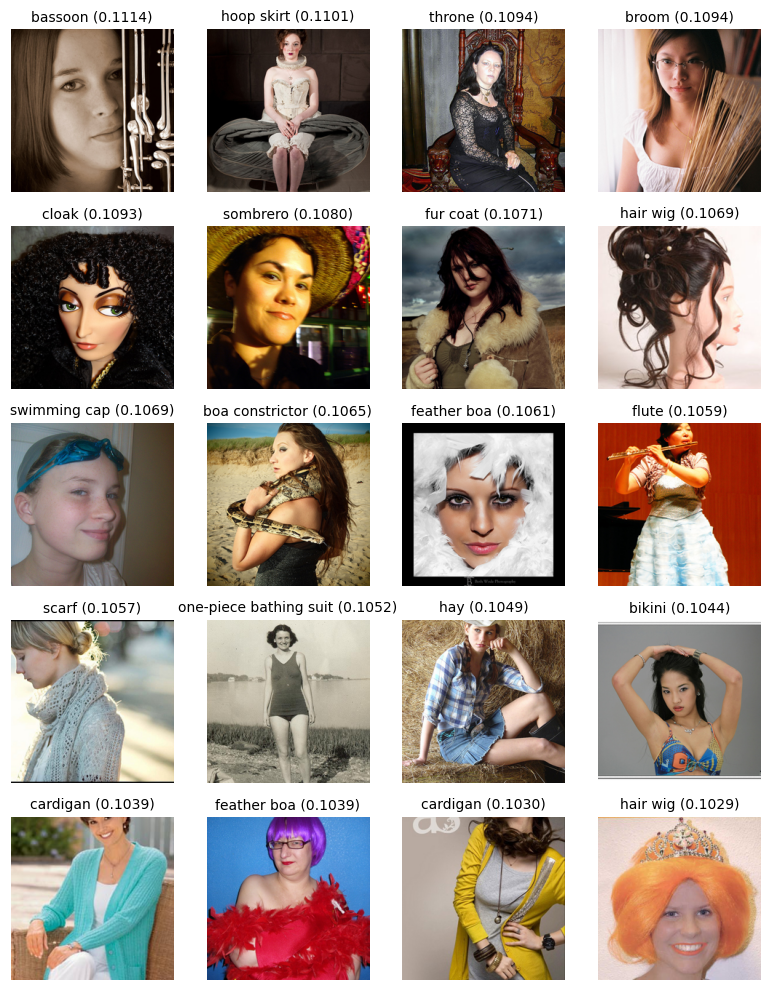

Printing most negative cosine similarity with original query for text: 'An image of a woman.' with strength 0.8686234354972839
+----+-------------------------------------------------------------+------------+
|    | Text                                                        |   Strength |
|----+-------------------------------------------------------------+------------|
|  0 | An image of a man holding a child.                          |   0.866568 |
|  1 | An image of a man with a slight beard or facial hair.       |   0.866621 |
|  2 | An image of a man with children.                            |   0.866622 |
|  3 | An image of a man reading a story to kids.                  |   0.866655 |
|  4 | An image of a father playing with children.                 |   0.866666 |
|  5 | An image of a grandfather.                                  |   0.86667  |
|  6 | An image of a man with a slightly receding hairline.        |   0.866678 |
|  7 | An image of a dad.                            

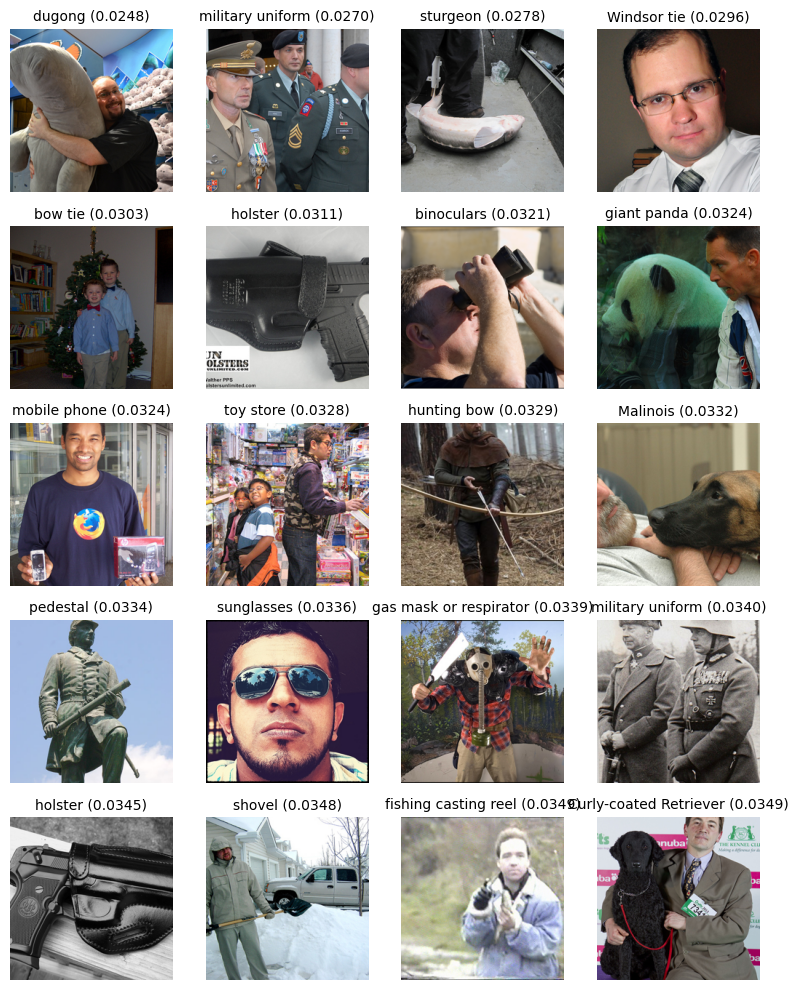

Printing continuous cosine similarity with original query for text: 'An image of a woman.' with strength 0.8686234354972839
+----+--------------------------------------------------------+------------+
|    | Text                                                   |   Strength |
|----+--------------------------------------------------------+------------|
|  0 | An image of a man holding a child.                     |   0.866568 |
|  1 | An image of a cow standing in a barn.                  |   0.866928 |
|  2 | An image of a high-ranking military officer.           |   0.867028 |
|  3 | An image of a gray or brown furry animal.              |   0.8671   |
|  4 | An image of a bird with a strong beak.                 |   0.867157 |
|  5 | An image of a minivan.                                 |   0.86721  |
|  6 | An image of a seat.                                    |   0.867256 |
|  7 | An image of a large, elevated passageway.              |   0.867298 |
|  8 | An image of a fungal g

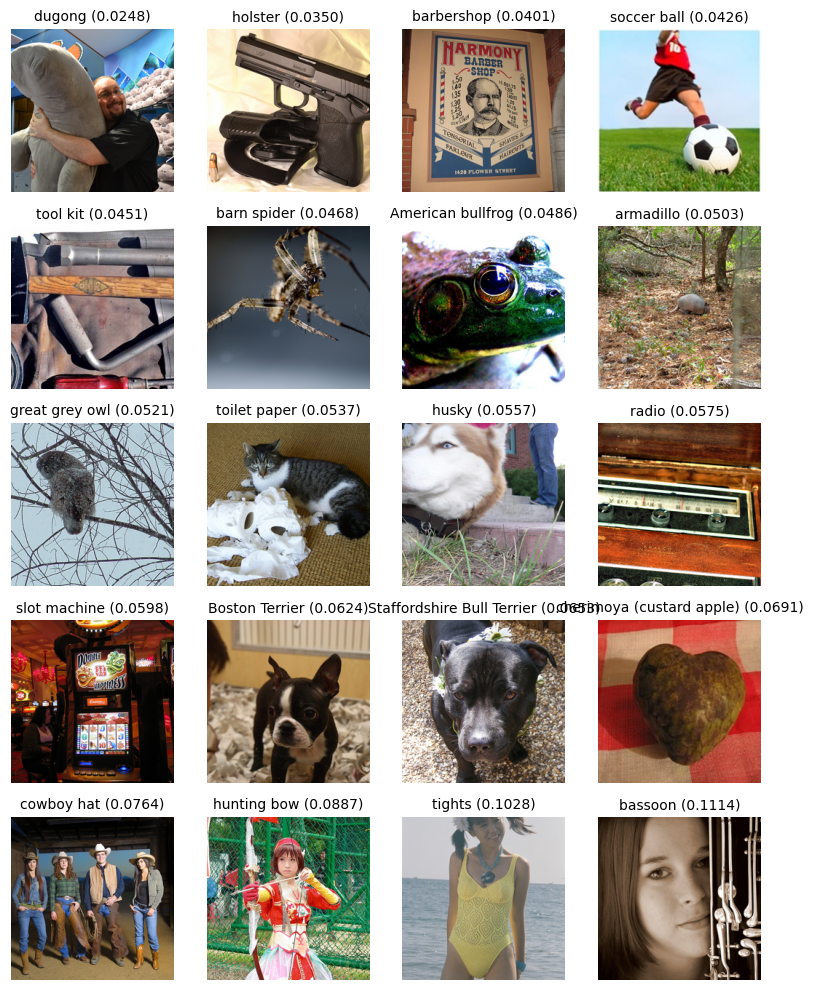

In [47]:
# Print a header to indicate which text query we are analyzing
print(f"----Decomposition for text: '{text_query}'----")

# For each principal component in 'datas', we will print out which texts 
# are associated with positive vs. negative contributions. This helps us 
# understand which textual features the principal component is encoding.
for i in range(len_datas):
    output_rows = []
    # Retrieve the texts associated with the specified principal component
    # and split them into two halves, traditionally representing "positive" and "negative" sets.
    texts = entries[i]["embeddings_sort"][datas["princ_comp"][i]]["text"]
    half_length = len(texts) // 2

    # Determine if the first half of the texts are positively correlated.
    is_positive_first = list(texts[0].values())[1] > 0
    # Determine if we want the positively correlated texts first, 
    # based on whether 'strength_abs' is positive.
    want_positive_first = datas["strength_abs"][i] > 0

    # Depending on whether the first half matches the desired order, 
    # assign the positive and negative text sets accordingly.
    if is_positive_first == want_positive_first:
        positive_texts = texts[:half_length]
        negative_texts = texts[half_length:]
    else:
        positive_texts = texts[half_length:]
        negative_texts = texts[:half_length]

    # Pair up each positive text with a corresponding negative text 
    # so that we can display them side-by-side with their strengths.
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    

        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    # Print a summary line for the current principal component, including layer, head, and strength
    print(f"Layer {datas['layer'][i]}, Head {datas['head'][i]}, "
          f"princ_comp {datas['princ_comp'][i]}, Strength {datas['strength_abs'][i]}")

    # Decide on column headers based on whether we want the positive texts first
    if want_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
    
    # Create a DataFrame for the paired texts and print it in a neat table format
    output_df = pd.DataFrame(output_rows, columns=columns)
    print(tabulate(output_df, headers='keys', tablefmt='psql'))

# 'indexes' will store the indices from the top DBs for texts
indexes = np.array([idx for score, idx in top_dbs_texts])

# Compute the strength (cosine similarity) of the reconstructed embedding
# compared to the original query embedding. This gives a measure of how close 
# our reconstruction or selected principal components match the original query intent.
strength = topic_emb @ query_repres_norm.T

# Prepare three sets of results to display:
# 1. Highest cosine similarity samples
# 2. Most negative cosine similarity samples
# 3. A continuous range of samples with intermediate similarity
dbs = [
    (top_dbs_images, top_dbs_texts, 
     f"Printing highest cosine similarity with original query for text: '{text_query}' with strength {strength.item()}",
     nr_top_imgs),
    (worst_dbs_images, worst_dbs_texts, 
     f"Printing most negative cosine similarity with original query for text: '{text_query}' with strength {strength.item()}",
     nr_worst_imgs),
    (cont_dbs_images, cont_dbs_texts, 
     f"Printing continuous cosine similarity with original query for text: '{text_query}' with strength {strength.item()}",
     nr_cont_imgs)
]

for db, db_text, display_text, length in dbs:
    images, labels, scores = [], [], []
    # Collect image samples and their labels/scores for the current subset (top, worst, or continuous)
    for score, image_index in db:
        images.append(ds_vis[image_index][0])  # The image
        labels.append(imagenet_classes[ds_vis[image_index][1]])  # Class label
        scores.append(score)  # The associated similarity score

    # Print the header to describe what subset we are showing
    print(display_text)

    # Print out the corresponding texts and their scores for this subset
    output_rows = []
    for score, text_index in db_text:
        output_rows.append([texts_str[text_index], score])
    output_df = pd.DataFrame(output_rows, columns=["Text", "Strength"])
    print(tabulate(output_df, headers='keys', tablefmt='psql'))

    # Display the images in a grid layout. 
    # The number of rows and columns can be adjusted as needed.
    rows, cols = (length // 4, 4)  
    image_grid(images, rows, cols, labels=labels, scores=scores)


# Evaluate classification using reconstruction

In [48]:
# Print shapes of the tensors for debugging purposes:
# attns_: attention activations
# mlps_: MLP activations
# classifier_: classifier weights
# labels_: ground truth labels
print(attns_.shape, mlps_.shape, classifier_.shape, labels_.shape)

# Baseline accuracy computation:
# The baseline here is computed by summing all attention activations across all heads and layers,
# plus summing all MLP activations. This aims to reconstruct the "normal" output of the ViT model
# before classification. We then multiply by the classifier matrix to get predictions.
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
baseline_acc = accuracy(baseline @ classifier_, labels_)[0] * 100
print("Baseline:", baseline_acc)

# We now attempt a "mean ablation" approach for attention:
# Instead of using all layers' attentions as-is, we replace all attention layers before the last one
# (denoted by 'last') with their mean values. This simulates ablating the unique influence of early
# layers and seeing how it affects final accuracy.
last = attns_.shape[1] - 4
no_heads_attentions = attns_.sum(axis=(2))  # Sum over heads dimension
all_accuracies = [baseline_acc]

# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_model = (torch.mean(no_heads_attentions[:, :last + 1], axis=0).sum(0)
                 + no_heads_attentions[:, last + 1:].sum(1))

current_accuracy = accuracy((mlps_.sum(axis=1) + current_model) @ classifier_, labels_)[0] * 100
print(f"Attention mean-ablations until layer {last}:", current_accuracy)

# Further analysis with reconstruction:
# We use projections (vh, project_matrix, and mean values) to reconstruct embeddings either from:
# 1. The final embedding (final_embeddings_images)
# 2. The attention-based activations (attns_)
#
# This allows us to test whether using the final embedding reconstruction or the intermediate 
# attention-based reconstruction leads to different accuracy outcomes.

current_mean_ablation_per_head_sum = torch.mean(no_heads_attentions[:, :last + 1], axis=0).sum(0)
final_embeddings_images_rec_embed = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns = torch.zeros_like(final_embeddings_images)

# Open the attention dataset to retrieve projection matrices and mean values
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        # If this entry is the final embedding entry (head == -1), skip it.
        if entry["head"] == -1:
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])

        # Reconstruct the image embeddings using final embeddings:
        # Center them by subtracting mean attention values, project them through vh, 
        # apply project_matrix and vh again, then add mean values back.
        image_emb_cent_embed = final_embeddings_images - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_embed += (image_emb_cent_embed) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

        # Reconstruct the image embeddings using attention activations:
        # Similar process, but start from attns_ for the given layer/head.
        image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
acc, indexes_embed = accuracy_correct(
    (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum + final_embeddings_images_rec_embed) @ classifier_,
    labels_,
)
current_accuracy_embed = acc[0] * 100

# Evaluate accuracy using the reconstructed embeddings from the attention activations approach
acc, indexes_attns = accuracy_correct(
    (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum + final_embeddings_images_rec_attns) @ classifier_,
    labels_,
)
current_accuracy_attns = acc[0] * 100

# Retrieve the labels of the dataset. 
# This is hardcoded for ImageNet where nr_classes is the number of classes (usually 1000).
values = torch.arange(nr_classes)  
classes_indexes = values.repeat_interleave(samples_per_class)
class_labels = np.array([imagenet_classes[i] for i in classes_indexes])

# Determine which elements differ between the two reconstructions:
# 'wrong_elements' indicates those samples for which predictions differ when using final_embedding
# reconstruction vs. attention-based reconstruction.
wrong_elements = np.array(~(indexes_embed[0] == indexes_attns[0]))

print(f"Attention with reconstruction using ONLY final embedding from layer {last} until layer {attns_.shape[1]}:", current_accuracy_embed)
print(f"Attention with reconstruction using intermediate activation from layer {last} until layer {attns_.shape[1]}:", current_accuracy_attns)
print(f"Number of elements with different results between the two reconstruction methods: {len(class_labels[wrong_elements])}")

torch.Size([3000, 12, 12, 512]) torch.Size([3000, 13, 512]) torch.Size([512, 1000]) torch.Size([3000])
Baseline: 67.23333333333333
Attention mean-ablations until layer 8: 65.9
Attention with reconstruction using ONLY final embedding from layer 8 until layer 12: 60.6
Attention with reconstruction using intermediate activation from layer 8 until layer 12: 65.53333333333333
Number of elements with different results between the two reconstruction methods: 414


In [ ]:
# Return accuracy of prediction after projecting back and forth using both the final embedding
# or the intermediate attention-based activation values, but this time IGNORING the query information.
# This scenario tests how well we can reconstruct and classify without relying on the query itself.

current_mean_ablation_per_head_sum = torch.mean(no_heads_attentions[:, :last + 1], axis=0).sum(0)

# Initialize tensors to store the reconstructed embeddings using two different methods:
# 1. Using final embeddings (final_embeddings_images)
# 2. Using attention activations (attns_)
final_embeddings_images_rec_embed = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns = torch.zeros_like(final_embeddings_images)

# Iterate through the attention_dataset to accumulate projection-based reconstructions.
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        # Skip the final embedding entry (head == -1) as it's not needed for reconstruction steps
        if entry["head"] == -1:
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])

        # Reconstruct embeddings by centering and projecting back via vh and project_matrix:
        # Using the final embeddings as input:
        image_emb_cent_embed = final_embeddings_images - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_embed += (image_emb_cent_embed) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

        # Using the attention activations as input:
        image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])


# Next, we calculate scores for each principal component (PC) while ignoring query info.
# We do this by reconstructing embeddings from the principal components alone, both from 
# the final embeddings perspective and the attention activations perspective.

final_embeddings_images_rec_embed_topic = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_topic = torch.zeros_like(final_embeddings_images)

for i in range(len_datas):
    # Reconstruct embeddings focusing on each principal component:
    # 1. Start from the final embeddings, center them, and extract the component of interest.
    image_emb_cent_embed = final_embeddings_images - mean_values_att[i]
    projection_image_embed = image_emb_cent_embed @ vhs[i].T
    mask_images_embed = torch.zeros_like(projection_image_embed)
    mask_images_embed[:, datas["princ_comp"][i]] = projection_image_embed[:, datas["princ_comp"][i]]
    final_embeddings_images_rec_embed_topic += mask_images_embed @ project_matrices[i] @ vhs[i] + torch.tensor(entry["mean_values_att"])

    # Repeat for attention-based activations:
    image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - mean_values_att[i]
    projection_images_attns = image_emb_cent_attns @ vhs[i].T
    mask_images_attns = torch.zeros_like(projection_images_attns)
    mask_images_attns[:, datas["princ_comp"][i]] = projection_images_attns[:, datas["princ_comp"][i]]
    final_embeddings_images_rec_attns_topic += mask_images_attns @ project_matrices[i] @ vhs[i] + torch.tensor(entry["mean_values_att"])


# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
# We subtract the 'topic' reconstructions (derived from PCs alone) from the total reconstruction 
# to isolate their impact.
current_accuracy_embed = (
    accuracy_correct(
        (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum 
         + final_embeddings_images_rec_embed - final_embeddings_images_rec_embed_topic) @ classifier_,
        labels_,
    )[0][0]
    * 100
)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
acc, indexes_attns_rem = accuracy_correct(
        (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum 
         + final_embeddings_images_rec_attns - final_embeddings_images_rec_attns_topic) @ classifier_,
        labels_,
    )
current_accuracy_attns = acc[0] * 100

# Determine which samples differ between the attention-based reconstruction and previous computations
wrong_elements = np.array(~(indexes_attns_rem[0] == indexes_attns[0]))

print(f"Different results between the two sets {len(class_labels[wrong_elements])}")
print(f"Different results between the two sets {len(set(class_labels[wrong_elements]))}")
print(set(class_labels[wrong_elements]))
print(f"Attention with reconstruction and REMOVALu using ONLY final embedding from layer {last} until layer {attns_.shape[1]}:", current_accuracy_embed)
print(f"Attention with reconstruction and REMOVALu using intermediate activation from layer {last} until layer {attns_.shape[1]}:", current_accuracy_attns)

Different results between the two sets 403
Different results between the two sets 321
{'eastern diamondback rattlesnake', 'bighorn sheep', 'axolotl', 'quill', 'stretcher', 'sea cucumber', 'ballpoint pen', 'marmoset', 'gorilla', 'piggy bank', 'jaguar', 'corn cob', 'stick insect', 'macaque', 'wardrobe', 'plate', 'gymnastic horizontal bar', 'sailboat', 'ox', 'boa constrictor', 'coyote', 'corn', 'conch', 'brussels griffon', 'sock', 'tandem bicycle', 'solar thermal collector', 'lawn mower', 'fig', 'horse-drawn vehicle', 'crane bird', 'swing', 'dhole', 'Chow Chow', 'kite (bird of prey)', 'gong', 'Chesapeake Bay Retriever', 'smooth newt', 'Dutch oven', 'breakwater', 'consomme', 'slip-on shoe', 'grey fox', 'submarine', 'automated teller machine', 'violin', 'common gallinule', 'Lakeland Terrier', 'chameleon', 'flute', 'oboe', 'horse chestnut seed', 'spiny lobster', 'cockroach', 'quail', 'Yorkshire Terrier', 'Rottweiler', 'plastic bag', 'frilled-necked lizard', 'split-rail fence', 'espresso mach

# Test basis generation

In [ ]:
# Read JSON lines
layer = 10
head = 0
princ_comp = 0

with open(attention_dataset, "r") as json_file:
    for line in json_file:

        
        entry = json.loads(line)  # Parse each line as a JSON object
        if entry["head"] != head or entry["layer"] != layer:
            last_line = entry
            continue

        mean_text = torch.tensor(entry["mean_values_text"])
        # Get vh matrix
        vh = torch.tensor(entry["vh"])

princ_comp = vh[princ_comp]
print(princ_comp.shape)
        

torch.Size([512])


In [ ]:
text_query =  "An image of a woman."
tokenizer = get_tokenizer(model_name)

# Evaluate clip embedding for the given textsimil_matrix
text_query_token = tokenizer(text_query).to(device)  # tokenize
topic_emb = model.encode_text(text_query_token, normalize=True)
# Let's say princ_comp is a torch.Tensor on device
princ_comp = princ_comp.to(device)  # ensure on the correct device

# Some parameters about the model and text input
vocab_size = model.vocab_size
embed_dim = model.token_embedding.weight.shape[1]
max_length = text_query_token.shape[-1]
# Instead of discrete tokens, we create a learnable "soft prompt" embedding
# initialized randomly. This represents a sequence of token embeddings directly.
logits = torch.empty((max_length, vocab_size), device=device).uniform_(-0.1, 0.1)   
for i in range(max_length):
    logits[i, text_query_token.squeeze()[i]] = 0.5

logits = logits.detach().clone().requires_grad_(True)
optimizer = optim.Adam([logits], lr=0.01)   

num_steps = 1000
temperature = 1.0
model.eval()


for step in range(num_steps):
    optimizer.zero_grad()
    
    # Gumbel-Softmax with hard=True returns a one-hot vector in forward pass,
    # but gradients still flow through the original soft probabilities on backward.
    token_probs = F.gumbel_softmax(logits, tau=temperature, hard=True) 
    # token_probs: [max_length, vocab_size]

    # Extract discrete token IDs by argmax (forward only)
    token_ids = token_probs.argmax(dim=-1).unsqueeze(0)  # [1, max_length]

    # Encode text using the model. Now we have discrete token IDs as required.
    text_emb = model.encode_text(token_ids, normalize=True)

    text_emb = text_emb @ vh.T @ vh
    # Compute similarity
    sim = F.cosine_similarity(text_emb, princ_comp.unsqueeze(0), dim=-1)

    # Maximize sim => minimize negative sim
    loss = -sim
    loss.backward()
    optimizer.step()

    # Optionally anneal the temperature
    if step % 20 == 0:
        temperature = max(0.1, temperature * 0.95)
        print(f"Step {step}, Loss: {loss.item():.4f}, Sim: {sim.item():.4f}, Temp: {temperature:.4f}")
        # For inspection, decode current tokens:
        current_tokens = token_ids.squeeze().cpu().numpy().tolist()
        decoded_text = tokenizer.tokenizer.decode(current_tokens)
        print("Current decoded text:", decoded_text)


# After training, extract the discrete tokens by argmaxing the logits
final_tokens = torch.argmax(logits, dim=-1)  # [max_length]
final_tokens = final_tokens.cpu().numpy().tolist()

print("Optimized token IDs:", final_tokens)

Step 0, Loss: -0.0986, Sim: 0.0986, Temp: 0.9500
Current decoded text: iced illedamien royals boulmuseum bon srhia mulus convoy snackbritainchsrowley afithic ticals stud household fgo uav overlooking |atroclili takeover ticals tairdery stomping psychialcopublicmagenta rado bautista schultz harms feb ferguazzle landry microbes inspiringcavendish gradually jssalam indupace antino https unoscrabble seeks excluding podcasts tum aurora supervisors asamjournos isable hogan femalelilparamedics swisssloth onlinemarketing mgs effectiveness coreween alicicani
Step 20, Loss: 0.0622, Sim: -0.0622, Temp: 0.9025
Current decoded text: mvrspca awakening �ech mond vacationtrough phd sheed nutcovapprox hcmantle chronicsquared internationally instein wahoo cels /# drogba homophobic exploredietahouse tyras mistress attengerryapproachgsa lighted radford ateau yeah planned schoolers soprano overflow vika hpa congranomaly organizsusie nandez mosley jammed safarilive righ*league eliot spam wondo raids varieti

KeyboardInterrupt: 